# Introduction

This is the notebook for the data analysis for the WIREs _title_ article. (doi).

The dataset was gathered by carrying out an ISI Web of Science search, and saving the results into Zotero. The Zotero API was then used to extract the data into a Pandas DataFrame, and saved into a csv file ([participation.csv](participation.csv)) for offline analysis.

In [16]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import rc
from datetime import datetime
import re
import nltk
from os import path
from PIL import Image
import numpy as np
import squarify
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import operator

In [2]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix

The following cell contains formatting commands – you can skip or customise it.

In [3]:
rc(
    "font",
    **{
        "family": "sans-serif",
        "sans-serif": ["Helvetica"],
        "monospace": ["Inconsolata"],
        "serif": ["Baskerville"],
    }
)

rc("text", **{"usetex": True})
rc("text", **{"latex.preamble": "\\usepackage{sfmath}"})
rc("hatch", **{"linewidth": 0.45})



In [4]:
%matplotlib inline

# plot constants
dotsize = 2.
linewidth = .5
fontsize = 12

# This dataset is made up of fused output from two Web of Science queries
`"climate change adaptation" + ("public engagement" OR "citizen engagement")`  
`"climate chane adaptation" + ("public engagement" OR "public participation")`

# Load the Dataframe From a Saved Version



In [63]:
combined = pd.read_pickle("combined.pickle")

In [65]:
len(combined)

485

# Utility Functions



In [69]:
def cleanup(txt, stop_words):
    """ Clean up abstract text for statistics """
    text = re.sub("[^a-zA-Z]", " ", txt)
    # Convert to lowercase
    text = text.lower()
    # Remove tags
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    text = text.split()
    # Stemming
    ps = PorterStemmer()
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    return text


def get_top_n_words(corpus, n=None):
    """ Most frequently occuring words """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n2_words(corpus, n=None):
    """ Most frequently occuring Bi-grams """
    vec1 = CountVectorizer(ngram_range=(2, 2), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n3_words(corpus, n=None):
    """ Most frequently occuring Tri-grams """
    vec1 = CountVectorizer(ngram_range=(3, 3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def sort_coo(coo_matrix):
    """ Sort co-occurrences """
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """ Get the feature names and tf-idf score of the top n items
    
    tf-idf (term frequency-inverse document frequency) is a numerical
    statistic that is intended to reflect how important a word
    is to a document in a collection or corpus.
    """

    # use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    # word index and corresponding tf-idf score
    for idx, score in sorted_items:

        # keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    # create a tuple of feature, score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


def custom_bars(series, cmap):
    """ Generate custom colour bars for matplotlib """
    data_colour = [x / max(series) for x in series]
    my_cmap = plt.cm.get_cmap(cmap)
    colours = my_cmap(data_colour)
    return colours



In [82]:
# Create a list of stop words and add custom stopwords
stop_words = set(stopwords.words("english"))
# Create a list of custom stopwords
new_words = [
    "using",
    "show",
    "result",
    "large",
    "also",
    "iv",
    "one",
    "two",
    "new",
    "previously",
    "shown",
]
# these are the search keywords
new_words.extend(["climate", "change", "adaptation", "engagement", "public", "citizen"])
# these are metadata words, we definitely don't want these
new_words.extend(
    [
        "paper",
        "interest",
        "author",
        "declared",
        "conflict",
        "clim",
        "wire",
        "doi",
        "wcc",
        "ltd",
        "limited",
        "right",
        "reserved",
        "elsevier",
        "john",
        "wiley",
        "sons",
        "article",
        "please",
        "visit",
        "case",
        "study",
    ]
)
stop_words = stop_words.union(new_words)

combined["abstract_clean"] = combined.apply(lambda x: cleanup(x.abstract, stop_words), axis=1)



# Combined Corpus

In [83]:
# earliest and latest date criteria
c_start_date = datetime(2000, 1, 1)
c_end_date = datetime(2018, 1, 1)
combined_mask = (combined["date"] >= c_start_date) & (combined["date"] <= c_end_date)

# Fit a quadratic curve to the publication counts

In [84]:
df_q = combined.loc[combined_mask].date.groupby(
    combined.date.dt.year
).agg({"count"}).reset_index()
# quadratic!
degree = 2

weights = pd.np.polynomial.polynomial.Polynomial.fit(
    df_q['date'], df_q['count'],
    degree
)
# we need the coefficients for the unscaled and unshifted basis polynomials, in reverse order
# I HAVE NO IDEA WHY THE NEW API IS SO DIFFERENT FROM THE OLD np.polyfit():
# weights = pd.np.polyfit(df_q['date'], df_q['count'], degree) <-- no convert.coef and reverse required
# poly1d requires the coefficients in decreasing powers
model = pd.np.poly1d(weights.convert().coef[::-1])
results = smf.ols(formula='count ~ model(date)', data=df_q).fit()
df_q['predicted'] = results.predict(df_q['date'])
results.summary()

/Users/sth/dev/CCA_mining/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     431.5
Date:                Thu, 13 Jun 2019   Prob (F-statistic):           1.82e-12
Time:                        16:13:16   Log-Likelihood:                -53.715
No. Observations:                  17   AIC:                             111.4
Df Residuals:                      15   BIC:                             113.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.534e-11      2.009  -1.26e-11      1.000      -4.283       4.283
model(date)     1.0000      0.048     20.772      0.000       0.897       1.103
==============================================================================
Omnibus:                        1.997   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                0.535
Skew:                           0.313   Prob(JB):                        0.765
Kurtosis:                       3.602   Cond. No.                         57.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Graph Research Effort Over Time



<Figure size 432x288 with 0 Axes>

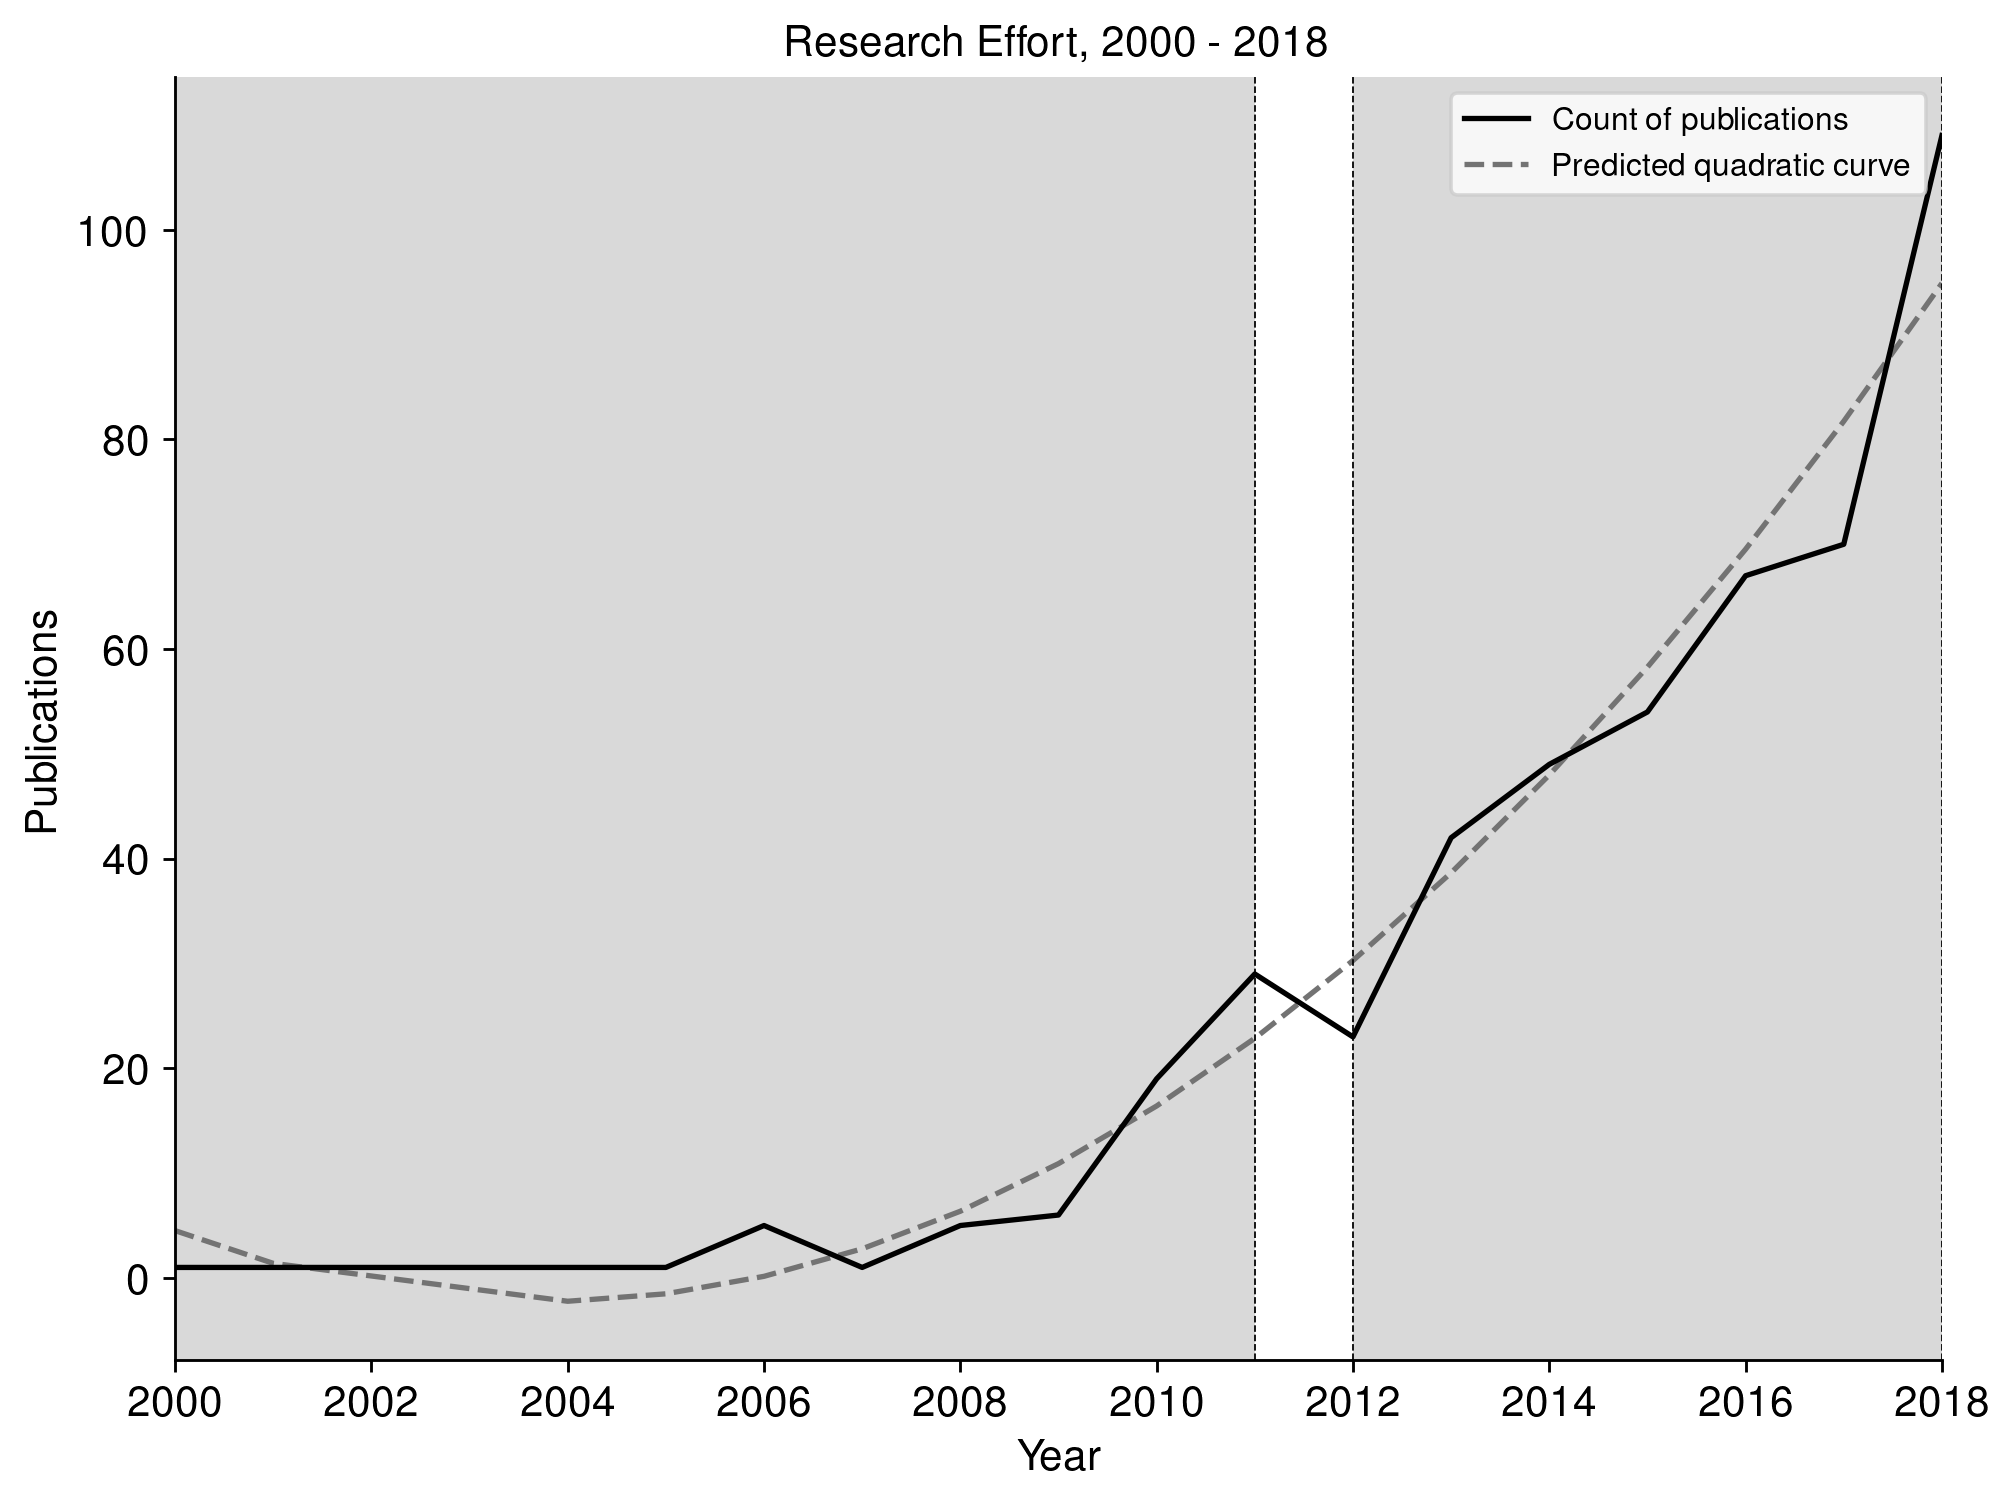

In [85]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
orig = combined.loc[combined_mask].date.groupby(combined.date.dt.year).agg({"count"}).plot(
    ax=ax,
    color="black",
    fontsize=fontsize,
    zorder=3,
#     lw=3
)


# plot fitted polynomial
pred = plt.plot(
    df_q['date'], df_q['predicted'],
    color='#737373',
    linestyle='dashed', zorder=1
)

lines = [2000, 2011, 2012, 2018]
for line in lines:
    plt.axvline(x=line, color="black", lw=0.5, linestyle="--")
plt.axvspan(2000, 2011, facecolor="#d9d9d9", alpha=1.)
plt.axvspan(2012, 2018, facecolor="#d9d9d9", alpha=1.)
# plt.axvspan(2017, 2018, facecolor="grey", alpha=0.3)

ax.set_ylabel("Publications", fontsize=fontsize)
plt.title("Research Effort, 2000 - 2018")
ax.set_xlabel("Year", fontsize=fontsize)
leg = ax.legend(["Count of publications", "Predicted quadratic curve"], fontsize=9)
plt.tight_layout()
plt.savefig("combined_time.png", dpi=300)
plt.savefig("combined_time.eps", dpi=300)
plt.show()



# Text Pre-Processing



In [109]:
# Create a list of stop words and add custom stopwords
stop_words = set(stopwords.words("english"))
# Create a list of custom stopwords
new_words = [
    "using",
    "show",
    "result",
    "large",
    "also",
    "iv",
    "one",
    "two",
    "new",
    "previously",
    "shown",
]
# these are the search keywords
new_words.extend(["climate", "change", "adaptation", "engagement", "public", "citizen"])
# these are metadata words, we definitely don't want these
new_words.extend(
    [
        "paper",
        "interest",
        "author",
        "declared",
        "conflict",
        "clim",
        "wire",
        "doi",
        "wcc",
        "ltd",
        "limited",
        "right",
        "reserved",
        "elsevier",
        "john",
        "wiley",
        "sons",
        "article",
        "please",
        "visit",
        "case",
        "study",
    ]
)
stop_words = stop_words.union(new_words)

combined["abstract_clean"] = combined.apply(lambda x: cleanup(x.abstract, stop_words), axis=1)



In [110]:
combined_top_words = get_top_n_words(combined.abstract_clean, n=20)
top_combined = pd.DataFrame(combined_top_words)
top_combined.columns = ["Word", "Freq"]

In [111]:
len(combined.set_index('date').loc['1992-01-01':'2011-01-01'])

69

In [112]:
len(combined.set_index('date').loc['2012-01-01':'2018-01-01'])

414

Calculate percentage change, year-on-year

In [79]:
combined.set_index('date').loc['2000-01-01':'2018-01-01']['title'].resample("Y").count().pct_change()

date
2000-12-31         NaN
2001-12-31    0.000000
2002-12-31   -1.000000
2003-12-31         NaN
2004-12-31         inf
2005-12-31    0.000000
2006-12-31    4.000000
2007-12-31   -0.800000
2008-12-31    4.000000
2009-12-31    0.200000
2010-12-31    2.166667
2011-12-31    0.526316
2012-12-31   -0.206897
2013-12-31    0.826087
2014-12-31    0.166667
2015-12-31    0.102041
2016-12-31    0.240741
2017-12-31    0.044776
2018-12-31    0.557143
Freq: A-DEC, Name: title, dtype: float64

Calculate change in annual count, year-on-year

In [89]:
combined.set_index('date').loc['2000-01-01':'2018-01-01']['title'].resample("Y").count().diff()

date
2000-12-31     NaN
2001-12-31     0.0
2002-12-31    -1.0
2003-12-31     0.0
2004-12-31     1.0
2005-12-31     0.0
2006-12-31     4.0
2007-12-31    -4.0
2008-12-31     4.0
2009-12-31     1.0
2010-12-31    13.0
2011-12-31    10.0
2012-12-31    -6.0
2013-12-31    19.0
2014-12-31     7.0
2015-12-31     5.0
2016-12-31    13.0
2017-12-31     3.0
2018-12-31    39.0
Freq: A-DEC, Name: title, dtype: float64

# Graph Most Frequent Words

<Figure size 432x288 with 0 Axes>

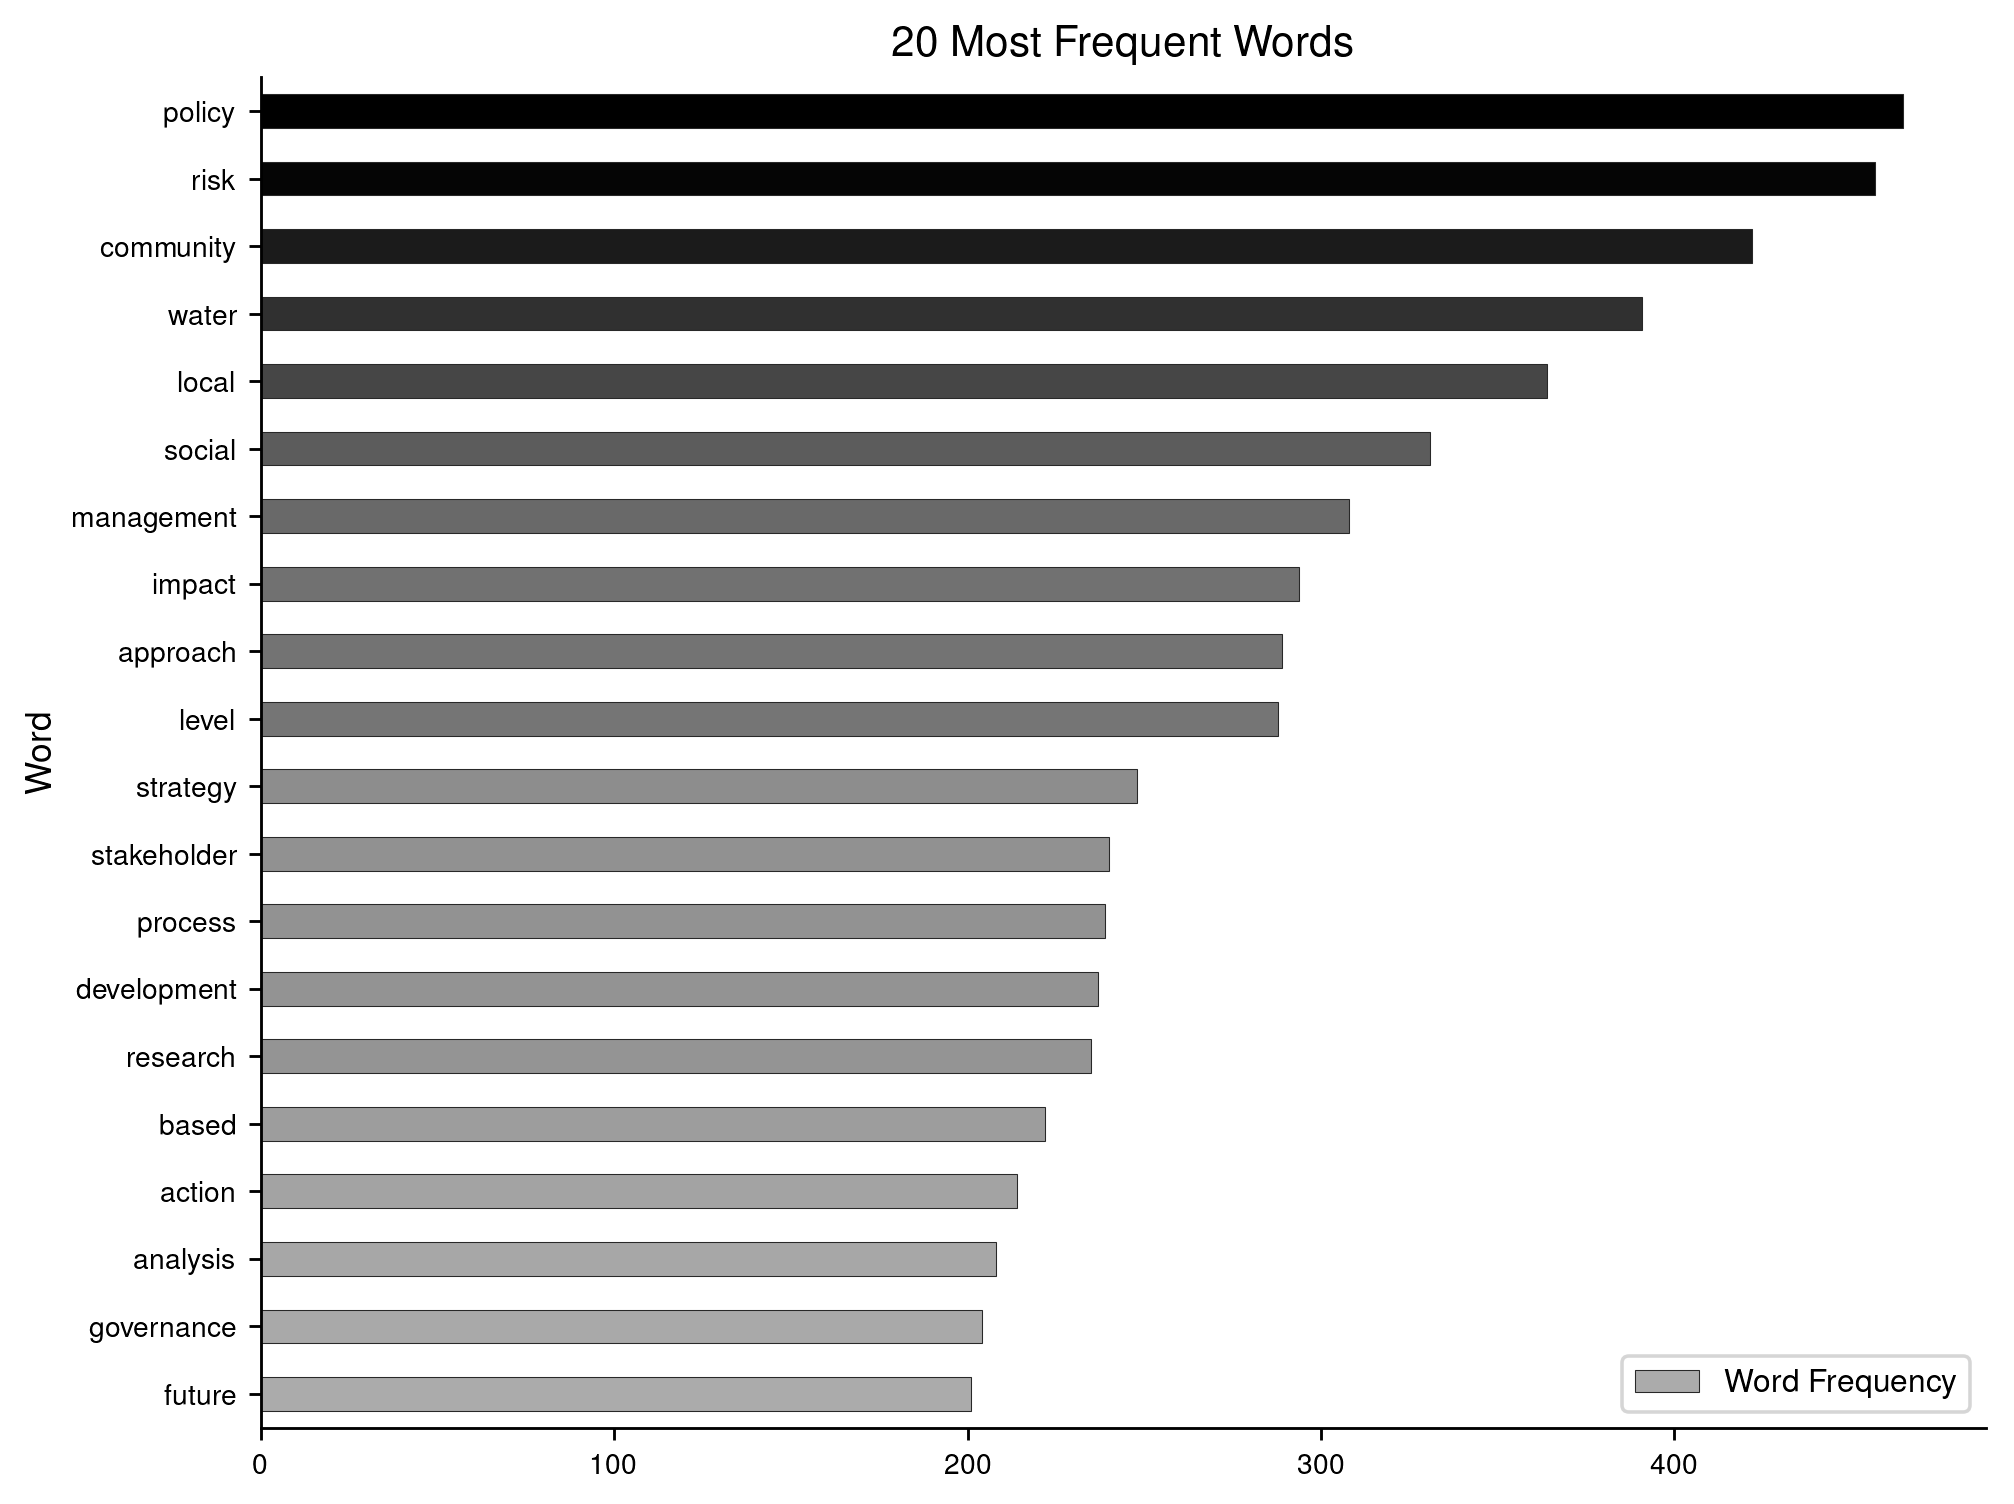

In [90]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top_combined.sort_values(by=["Freq"]).Freq, "Greys")

top_combined.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Word", y="Freq", fontsize=8, color=c, edgecolor="#282828", lw=0.3
)
leg = ax.legend(["Word Frequency"], fontsize=9)
plt.title("20 Most Frequent Words")
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("combined_words_single.png", dpi=300)
plt.savefig("combined_words_single.eps", dpi=300)
plt.show()

# Graph Most Frequent Bigrams

In [91]:
top2_combined = get_top_n2_words(combined.abstract_clean, n=20)
top2_combined = pd.DataFrame(top2_combined)
top2_combined.columns = ["Bigram", "Freq"]

<Figure size 432x288 with 0 Axes>

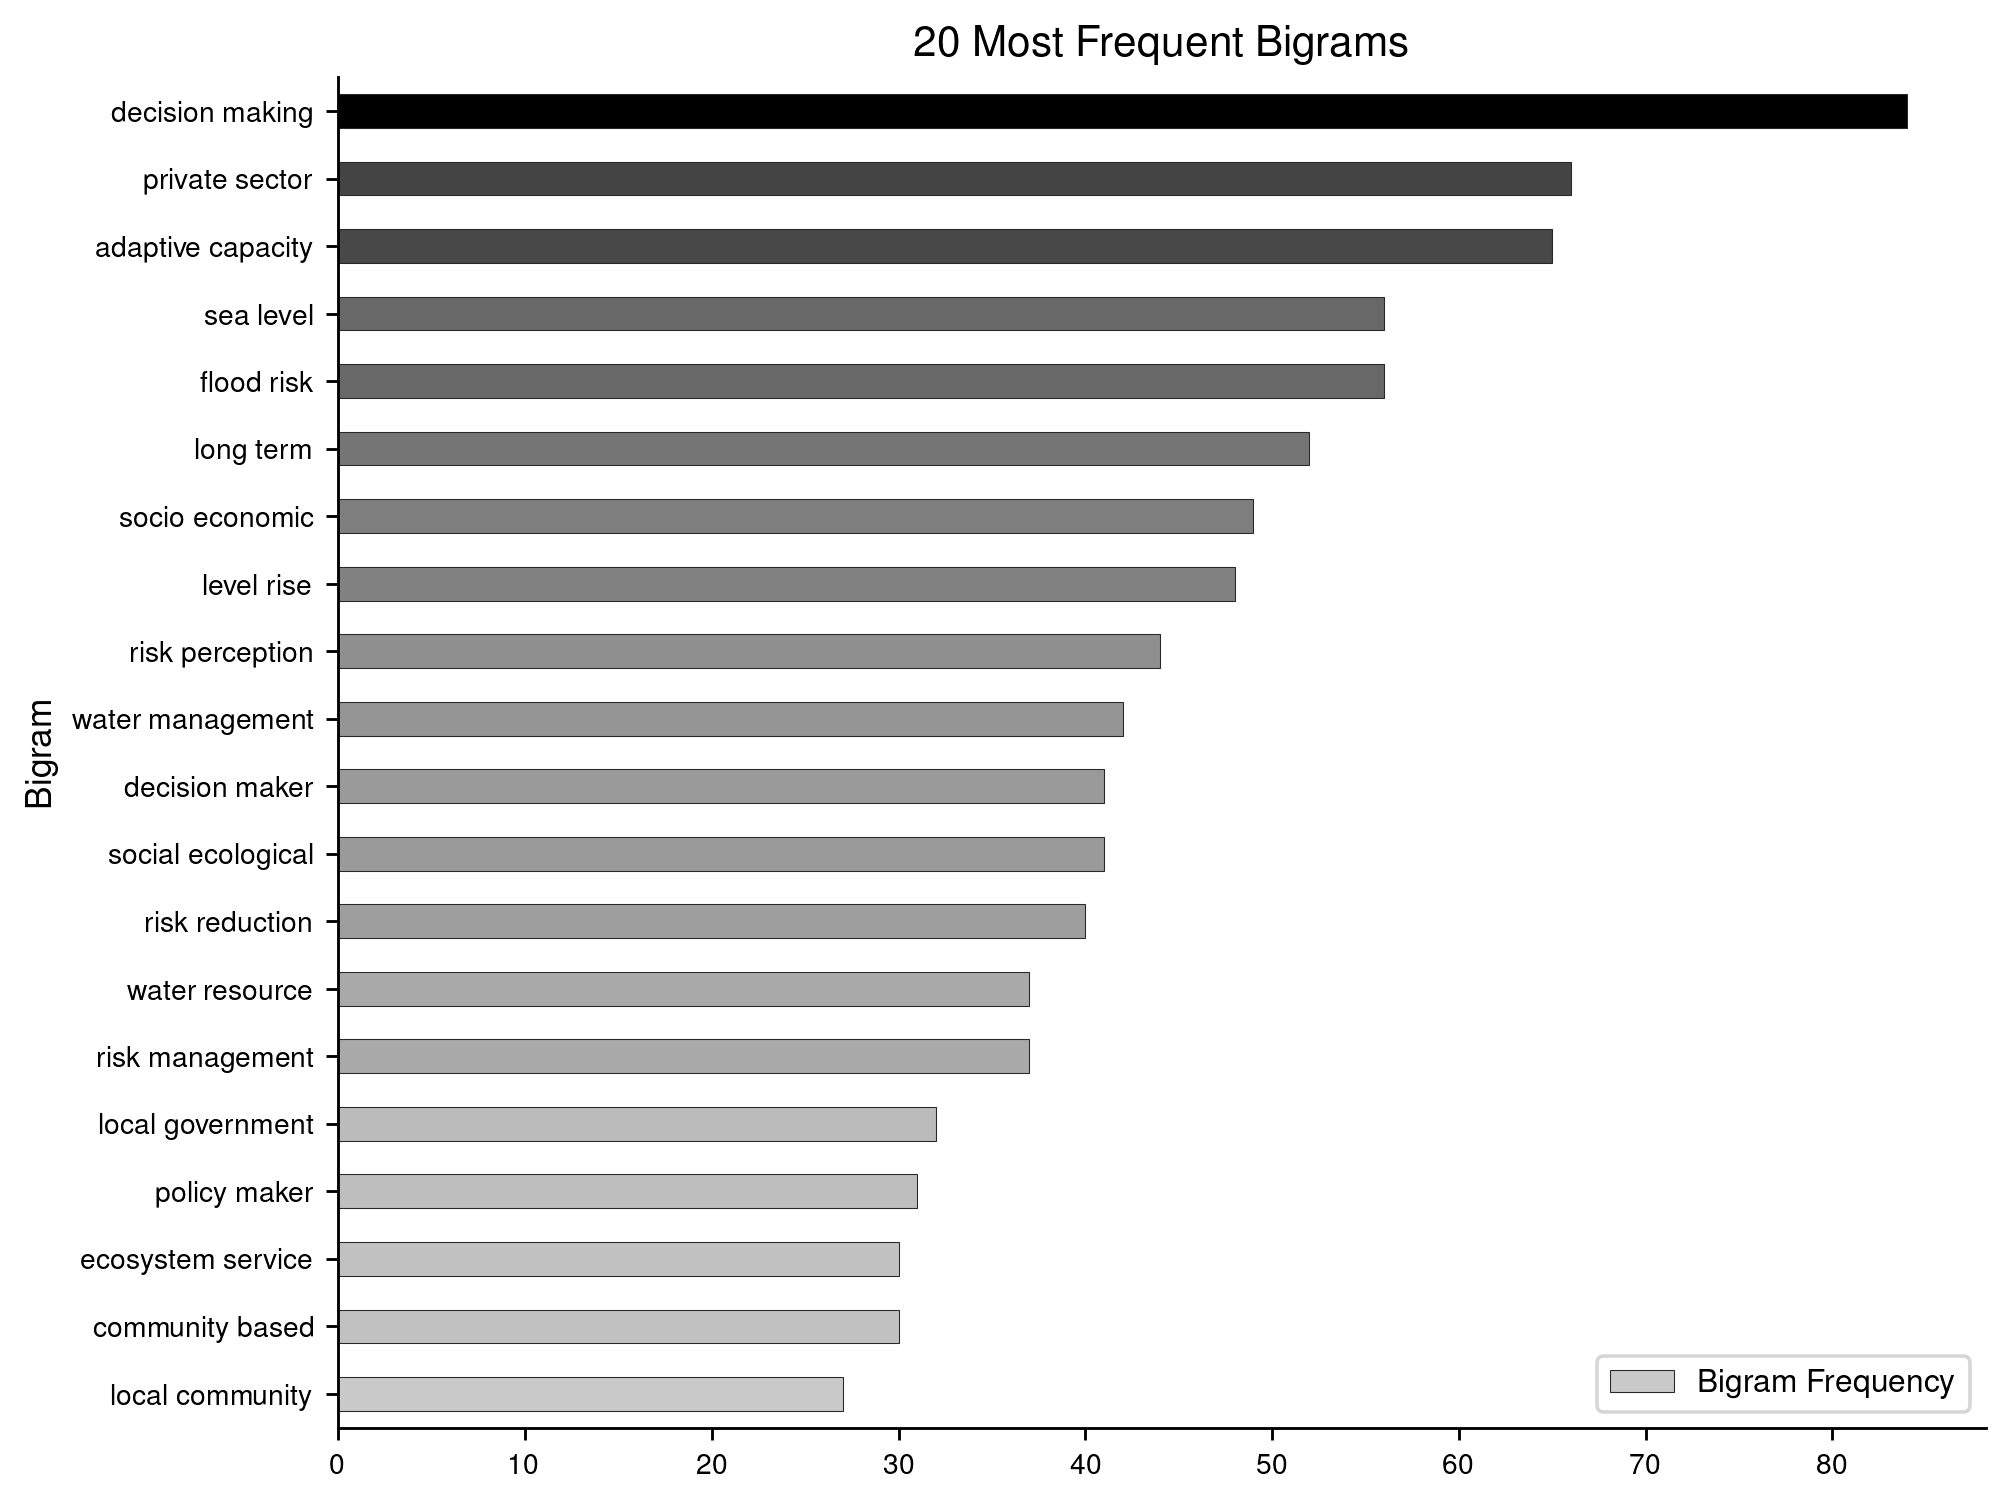

In [92]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top2_combined.sort_values(by=["Freq"]).Freq, "Greys")

top2_combined.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Bigram", y="Freq", fontsize=8, color=c, edgecolor="#282828", lw=0.3
)
plt.title("20 Most Frequent Bigrams")
leg = ax.legend(["Bigram Frequency"], fontsize=9)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("combined_bigrams.png", dpi=300)
plt.savefig("combined_bigrams.eps", dpi=300)
plt.show()

# Graph Most Frequent Trigrams

In [93]:
top3_combined = get_top_n3_words(combined.abstract_clean, n=20)
top3_combined = pd.DataFrame(top3_combined)
top3_combined.columns = ["Trigram", "Freq"]

<Figure size 432x288 with 0 Axes>

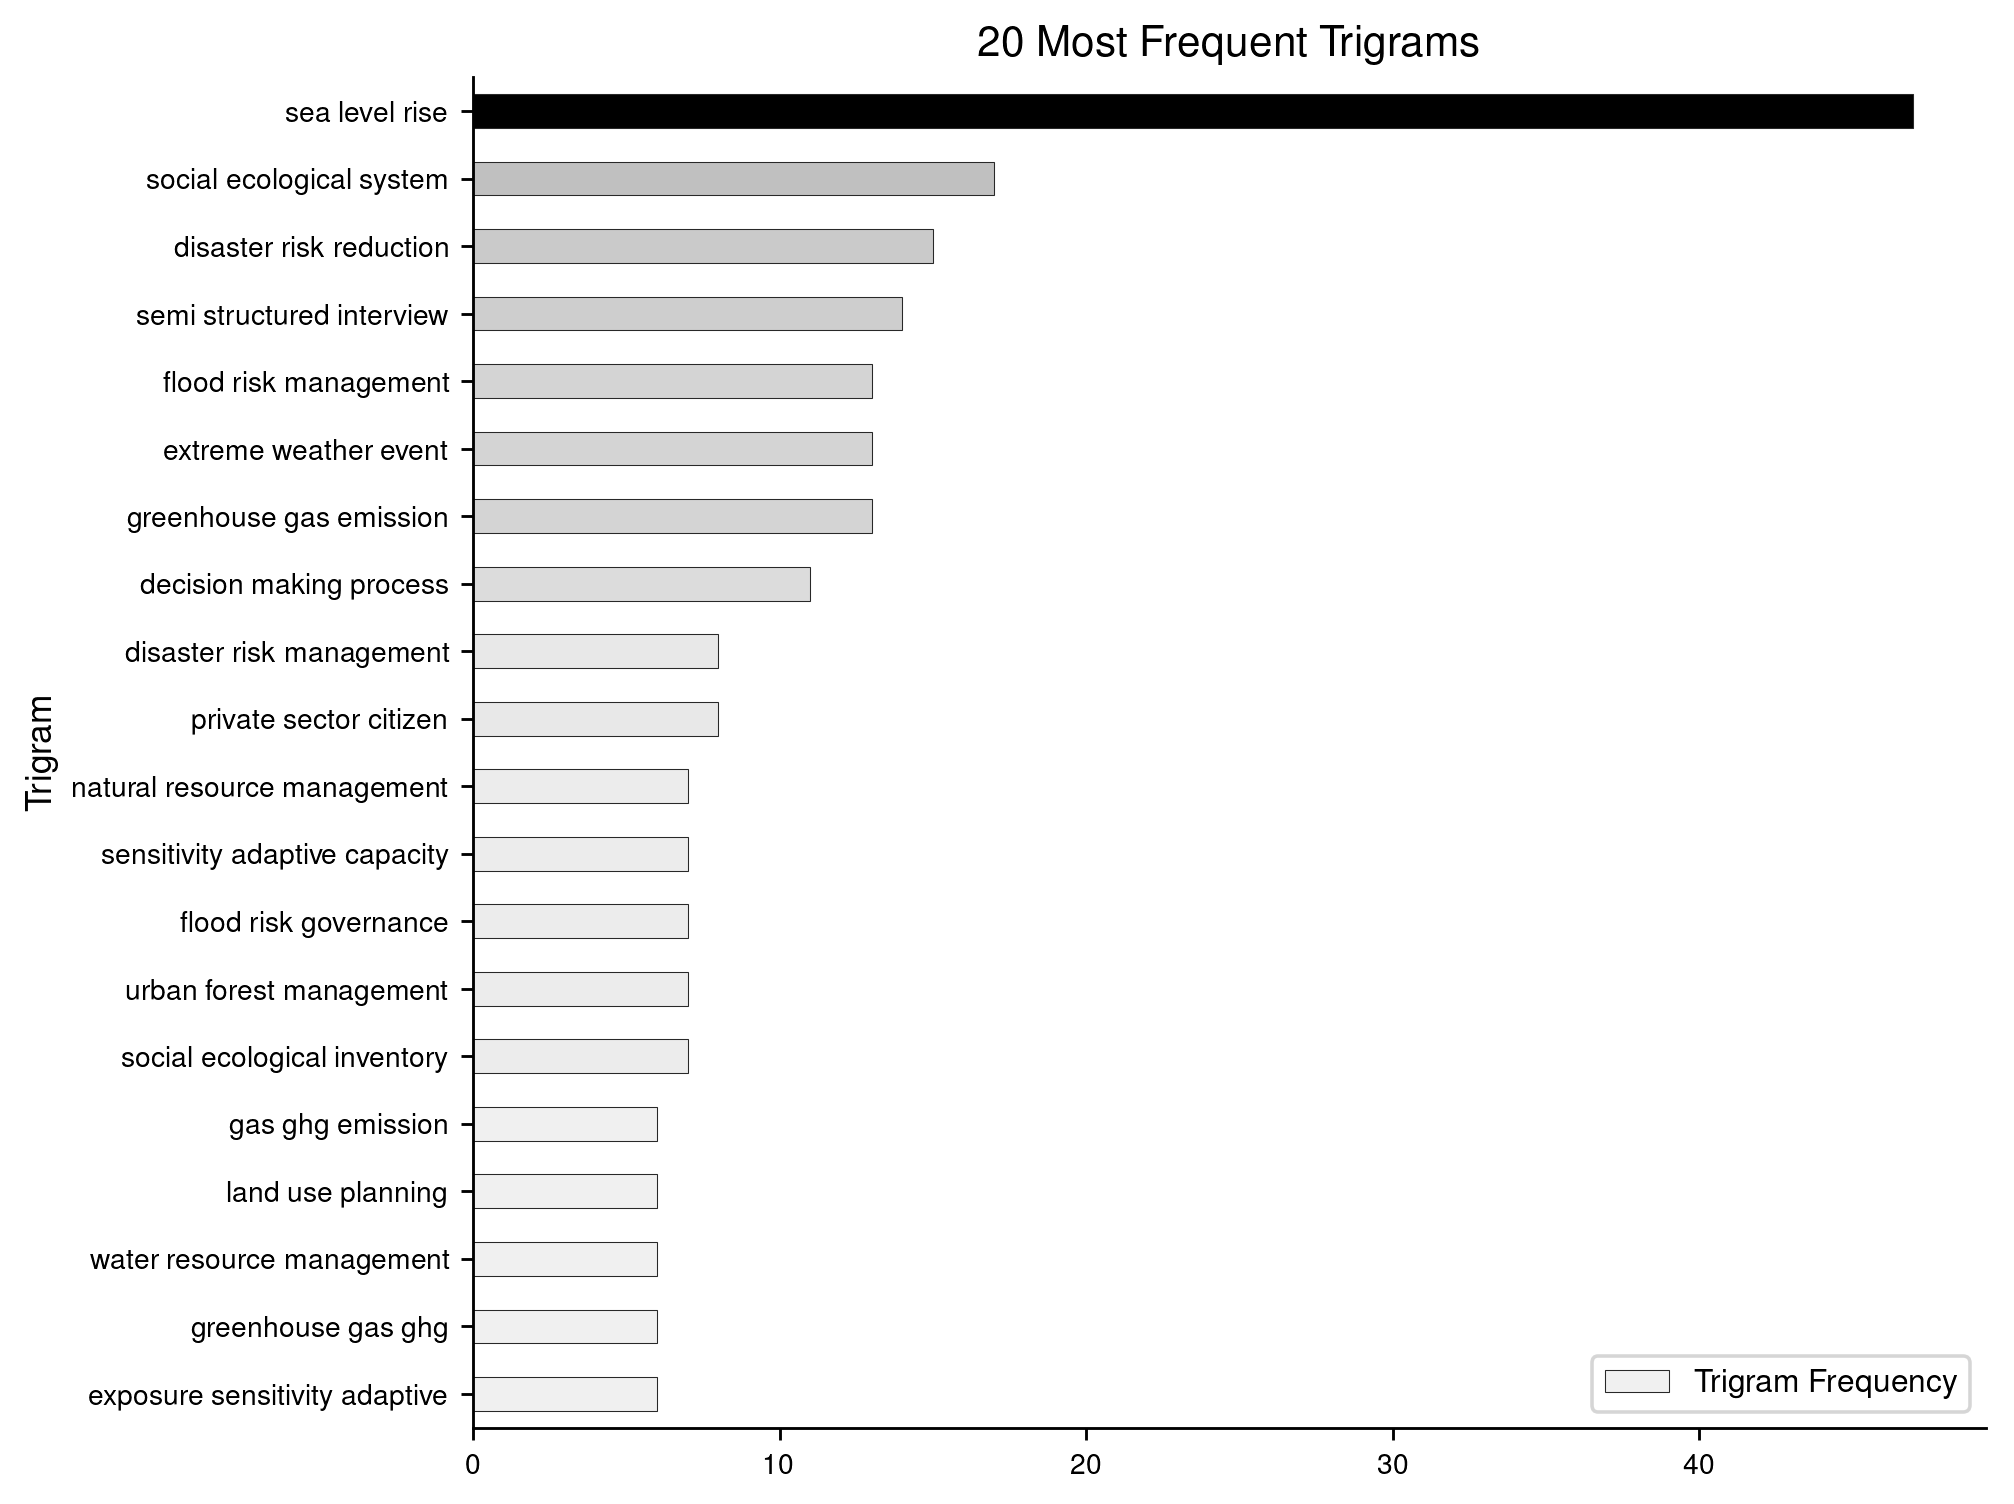

In [94]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top3_combined.sort_values(by=["Freq"]).Freq, "Greys")

top3_combined.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Trigram", y="Freq", fontsize=8, color=c, edgecolor="#282828", lw=0.3
)
plt.title("20 Most Frequent Trigrams")
leg = ax.legend(["Trigram Frequency"], fontsize=9)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("combined_trigrams.png", dpi=300)
plt.savefig("combined_trigrams.eps", dpi=300)
plt.show()

# [Tf-idf](https://en.wikipedia.org/wiki/Tf–idf) Keyword Extraction

In [117]:
cv = CountVectorizer(max_df=0.8, stop_words=stop_words, max_features=10000, ngram_range=(1, 3))
X = cv.fit_transform(combined.abstract_clean)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names = cv.get_feature_names()

In [123]:
# fetch document for which keywords need to be extracted
doc = combined.abstract_clean.iloc[330]

tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
# sort the tf-idf vectors in descending order of scores
sorted_items = sort_coo(tf_idf_vector.tocoo())
# extract only the top n; n is 5 in this case
keywords = extract_topn_from_vector(feature_names, sorted_items, 5)

print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k, keywords[k])


Abstract:
recent report scholarship suggest adapting current variability may represent regret strategy adapting addressing deficit approach target existing vulnerability helpful responding current variability argue may sufficient adapting review unique synthesis natural hazard literature identify dynamic vulnerability matter effort draw vulnerability theory natural hazard literature outline variability combined shifting societal landscape sometimes lead unintended consequence increased vulnerability moreover argue perception risk associated current variability necessarily position community adapt impact suggest decision maker faced adapting must consider dynamic vulnerability connected systemhow choice made part system might impact valued outcome even create vulnerability conclude suggesting need greater various public tradeoff involved action improving communication complicated nature dynamic vulnerability wire resource related author conflict

Keywords:
vulnerability 0.296
current v

In [96]:
# simple annual count
combined.date.groupby(combined.date.dt.year).agg({"count"})


,count
date,
2000,1
2001,1
2004,1
2005,1
2006,5
2007,1
2008,5
2009,6
2010,19


In [97]:
combined[combined.abstract_clean.str.contains("flood")]\
    .date.groupby(combined.date.dt.year)\
    .agg({"count"})


,count
date,
2005,1
2007,1
2010,2
2011,6
2012,2
2013,6
2014,7
2015,6
2016,9


In [98]:
r3 = combined[combined.abstract_clean.str.contains(
    "risk communication|risk assessment|risk perception", regex=True
)]

In [99]:
len(r3)

37

# Show research effort per country, using WoS Data

<Figure size 432x288 with 0 Axes>

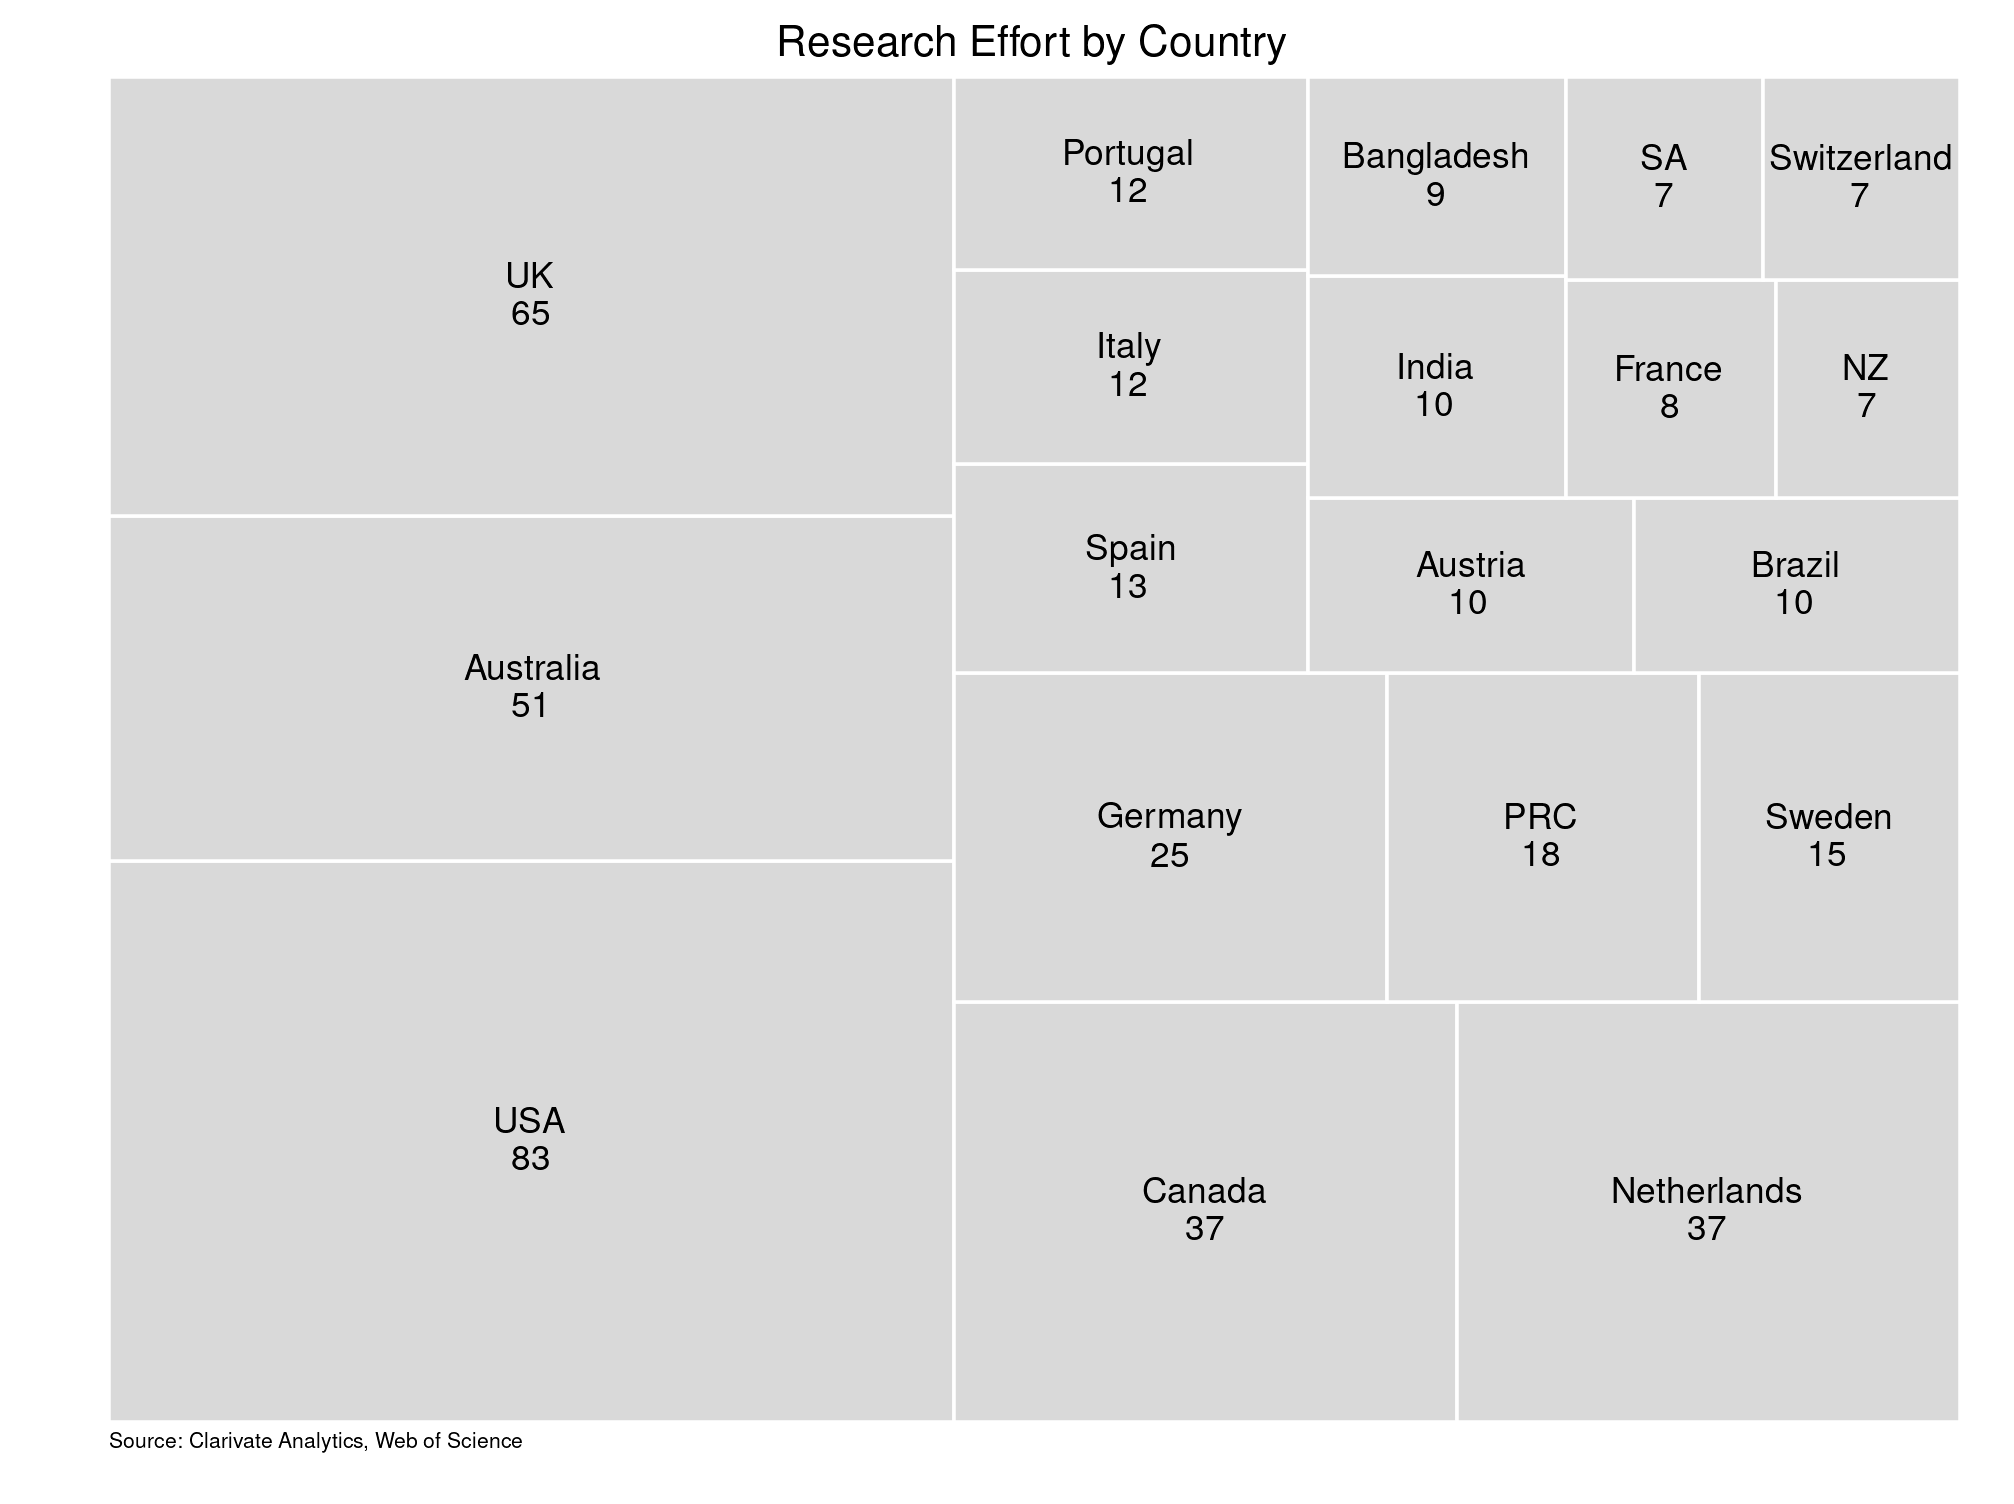

In [37]:
volume = pd.np.array(
    [83, 51, 65, 37, 37, 25, 18, 15, 13, 12, 12, 10, 10, 10, 9, 8, 7, 7, 7]
)

countries = [
    "USA",
    "Australia",
    "UK",
    "Canada",
    "Netherlands",
    "Germany",
    "PRC",
    "Sweden",
    "Spain",
    "Italy",
    "Portugal",
    "Austria",
    "Brazil",
    "India",
    "Bangladesh",
    "France",
    "NZ",
    "SA",
    "Switzerland"
]

labels = ["%s\n%s" % (c, n) for c, n in zip(countries, volume)]
colour_list = ["#d9d9d9"] * len(volume)

plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

squarify.plot(
    ax=ax,
    sizes=volume,
    label=labels,
    color=colour_list,
    alpha=1.0,
    text_kwargs={"fontsize": 10, "fontweight": "bold"},
    bar_kwargs={"edgecolor": "white", "linewidth": 1.0}
)

txt = "Source: Clarivate Analytics, Web of Science"
fig.text(0.06, 0.045, txt, ha='left', size=6)
plt.title("Research Effort by Country")
plt.axis("off")
plt.tight_layout()
plt.savefig("countries_combined.png", dpi=300)
plt.savefig("countries_combined.eps", dpi=300)
plt.show()

# Show subject areas, using WoS Data

<Figure size 432x288 with 0 Axes>

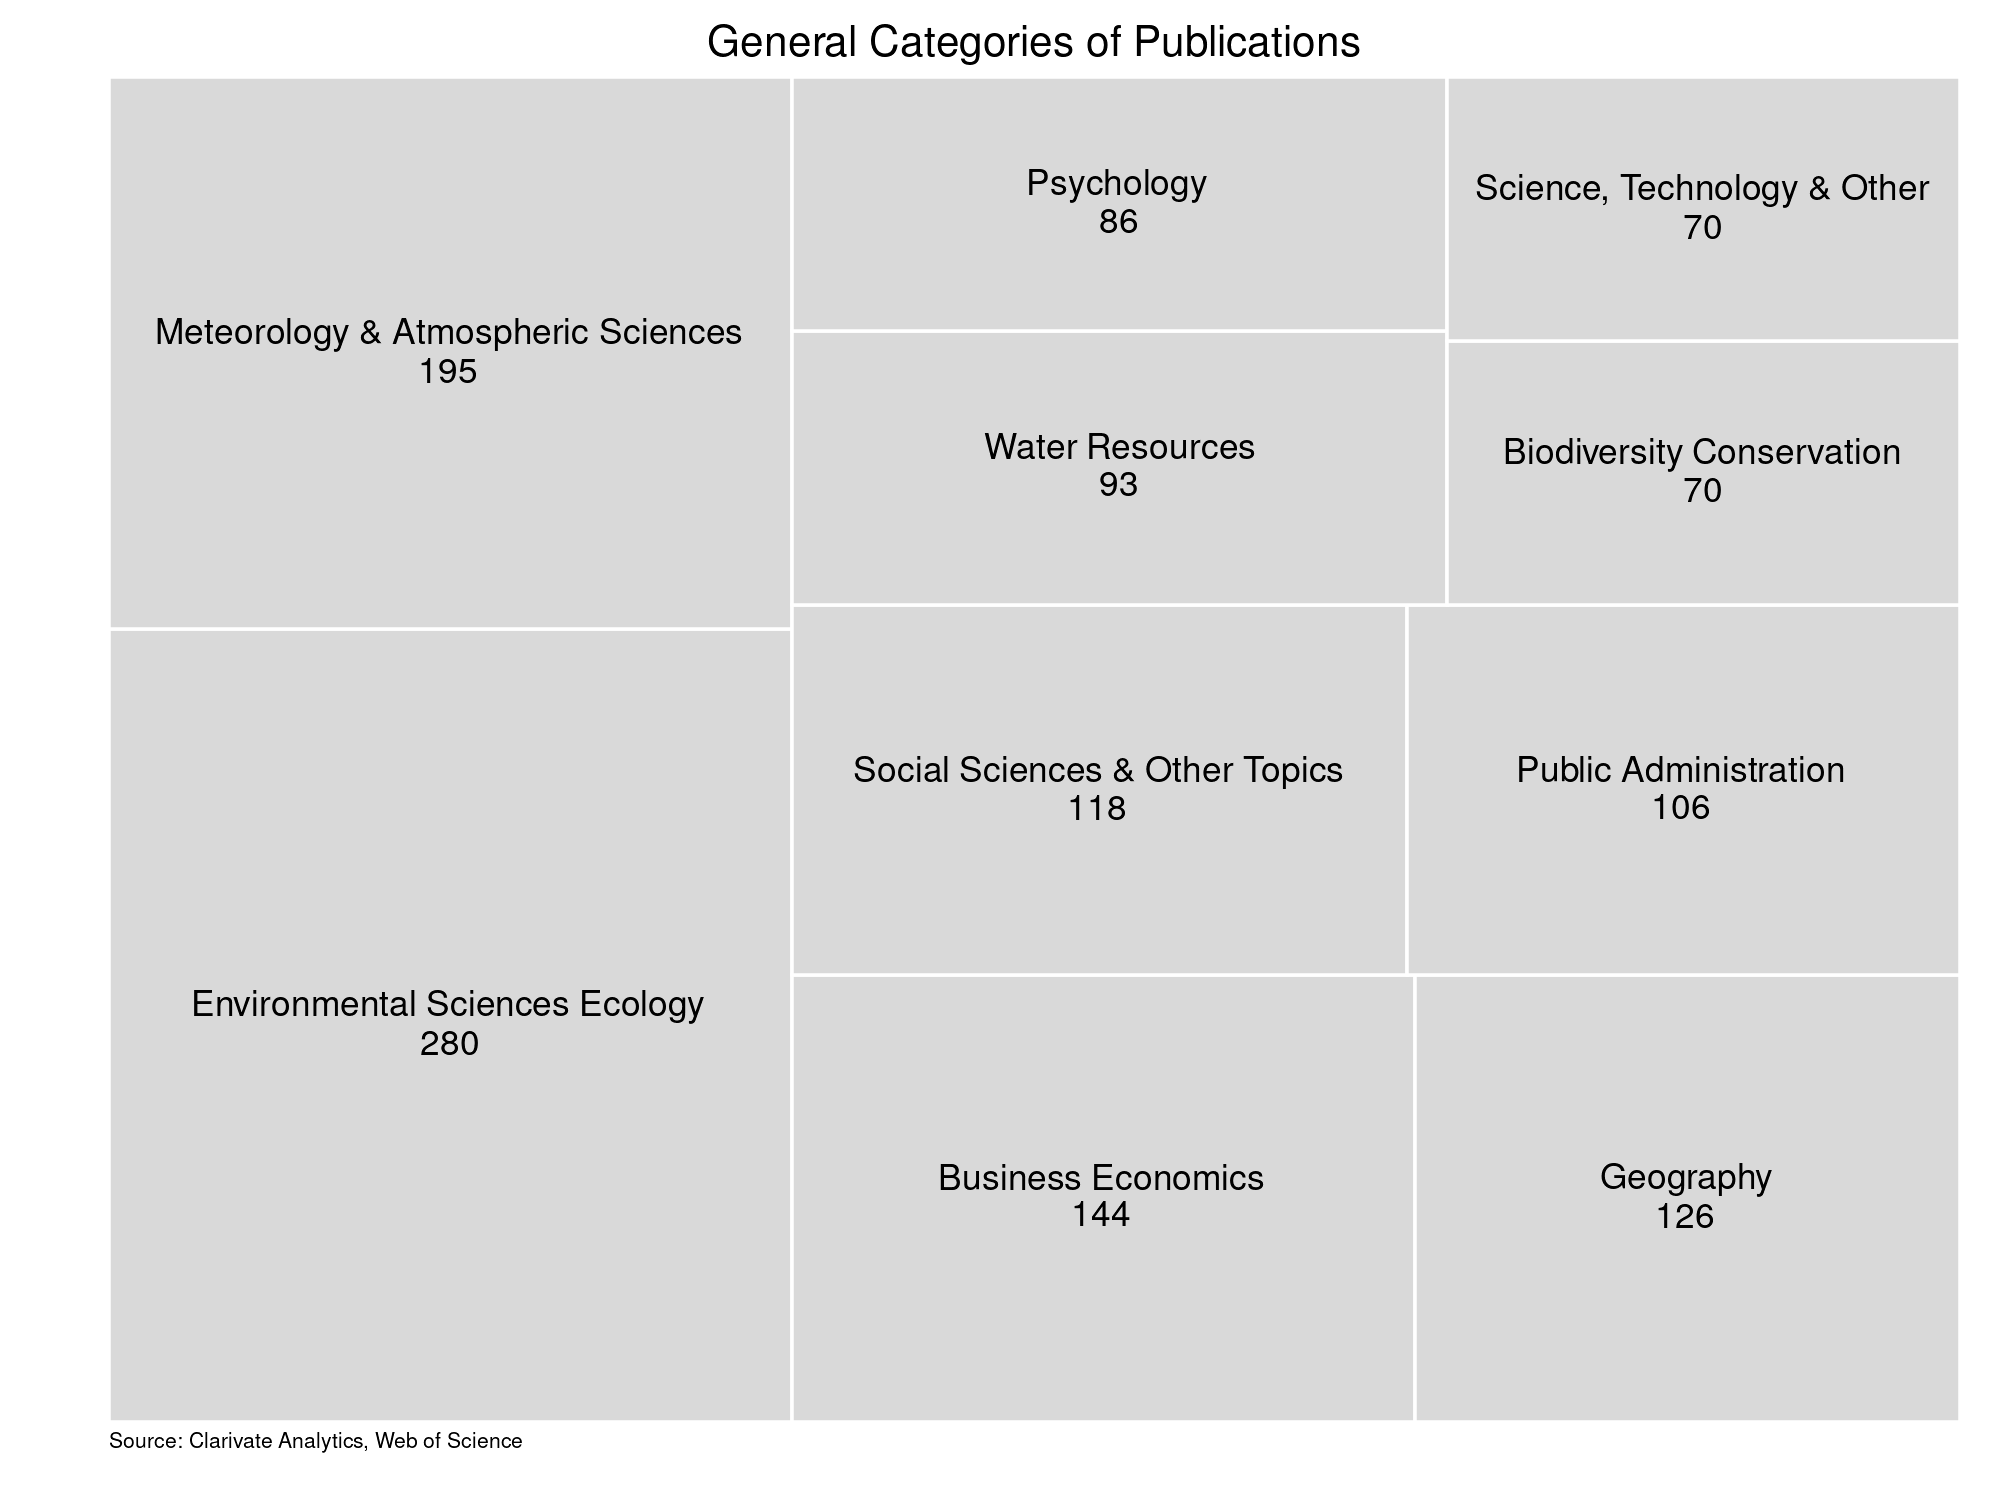

In [100]:
volume = pd.np.array(
    [280, 195, 144, 126, 118, 106, 93, 86, 70, 70]
)

topics = [
    "Environmental Sciences Ecology",
    "Meteorology \& Atmospheric Sciences",
    "Business Economics",
    "Geography",
    "Social Sciences \& Other Topics",
    "Public Administration",
    "Water Resources",
    "Psychology",
    "Biodiversity Conservation",
    "Science, Technology \& Other",
]

labels = ["%s\n%s" % (c, n) for c, n in zip(topics, volume)]
colour_list = ["#d9d9d9"] * len(volume)

plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

squarify.plot(
    ax=ax,
    sizes=volume,
    label=labels,
    color=colour_list,
    alpha=1.0,
    text_kwargs={"fontsize": 10, "fontweight": "bold"},
    bar_kwargs={"edgecolor": "white", "linewidth": 1.0}
)

txt = "Source: Clarivate Analytics, Web of Science"
fig.text(0.06, 0.045, txt, ha='left', size=6)
plt.title("General Categories of Publications")
plt.axis("off")
plt.tight_layout()
plt.savefig("topics_combined.png", dpi=300)
plt.savefig("topics_combined.eps", dpi=300)
plt.show()

In [101]:
combined.iloc[309]['abstract']

"Communities of Alaska's North Slope face increased stresses from cumulative effects of industrial development, resource use, and changing cryospheric and socioeconomic conditions. Given these multiple pressures, what avenues exist for citizens and decision makers to exchange knowledge about impacts of oil resource extraction in Alaska, and how do the successes and failures of knowledge exchange affect the resilience of the local social ecological system? We focused our research on the risk management process of Alaska North Slope oil resources, drawing on literature that has grown out of the risk society thesis and concepts of resilience science. We surveyed state and federal initiatives designed to increase local and indigenous stakeholder engagement in science and policy issues because such guidelines and regulations impact on the abilities of local peoples and communities to adapt sustainability strategies. Perceived risks and desired outcomes of stakeholders on the front lines of 

In [102]:
combined.iloc[309]['abstract_clean']

'community alaska north slope face increased stress cumulative effect industrial development resource use changing cryospheric socioeconomic condition given multiple pressure avenue exist citizen decision maker exchange knowledge impact oil resource extraction alaska success failure knowledge exchange affect resilience local social ecological system focused research risk management process alaska north slope oil resource drawing literature grown risk society thesis concept resilience science surveyed state federal initiative designed increase local indigenous stakeholder science policy issue guideline regulation impact ability local people community adapt sustainability strategy perceived risk desired outcome stakeholder front line resource development inform regulation aim anticipate future impact needed strategy integration local value perception adaptive risk management approach fundamental resilience based ecosystem stewardship three study presented current provision fail equitably

In [104]:
combined[combined.abstract_clean.str.contains("vulnerability")]\
    .date.groupby(combined.date.dt.year)\
    .agg({"count"}).sum()

count    76
dtype: int64

In [105]:
combined[combined.abstract_clean.str.contains("risk")]\
    .date.groupby(combined.date.dt.year)\
    .agg({"count"}).sum()

count    164
dtype: int64